In [1]:
! pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 32.6 MB/s 


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow_probability as tfp
from tensorflow.python.ops.numpy_ops import np_config
from keras.preprocessing.image import ImageDataGenerator
import os
from zipfile import ZipFile as zipfile
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil as sh
from itertools import repeat
import collections.abc
import tensorflow_addons as tfa
np_config.enable_numpy_behavior()
tf.keras.backend.set_image_data_format('channels_first')

In [3]:
tfp.__version__

'0.16.0'

In [4]:
tf.__version__

'2.8.2'

In [5]:
def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable):
            return x
        return tuple(repeat(x, n))
    return parse


to_1tuple = _ntuple(1)
to_2tuple = _ntuple(2)
to_3tuple = _ntuple(3)
to_4tuple = _ntuple(4)
to_ntuple = _ntuple

In [6]:
def droppath(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob

    bernoulli_dist = tfp.distributions.Bernoulli(probs=keep_prob)
    shape = (x.shape[0],) + (1,) * (tf.rank(x).numpy() - 1)
    random_tensor = bernoulli_dist.sample(sample_shape=shape)

    if keep_prob > 0.0 and scale_by_keep:
        tf.divide(random_tensor, keep_prob)

    return x * random_tensor


class DropPath(keras.layers.Layer):
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def call(self, x, **kwargs):
        return droppath(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob, 3):0.3f}'


class Mlp(keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=tf.nn.gelu, bias=True, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = to_2tuple(bias)
        drop_probs = to_2tuple(drop)

        self.fc1 = keras.layers.Dense(hidden_features, use_bias=bias[0])
        self.act = act_layer
        self.drop1 = keras.layers.Dropout(drop_probs[0])
        self.fc2 = keras.layers.Dense(out_features, use_bias=bias[1])
        self.drop2 = keras.layers.Dropout(drop_probs[1])

    def call(self, x, **kwargs):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)

        return x


class Identity(keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x, **kwargs):
        return x


class Attention(keras.layers.Layer):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = keras.layers.Dense(dim * 3, use_bias=qkv_bias)
        self.attn_drop = keras.layers.Dropout(attn_drop)
        self.proj = keras.layers.Dense(dim)
        self.proj_drop = keras.layers.Dropout(proj_drop)

    def call(self, x, **kwargs):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(16, N, 3, self.num_heads, C // self.num_heads).transpose((2, 0, 3, 1, 4))
        q, k, v = tf.unstack(qkv, axis=0)

        attn = (q @ tf.experimental.numpy.swapaxes(k, -2, -1)) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn)

        x = tf.experimental.numpy.swapaxes((attn @ v), 1, 2).reshape(16, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class LayerScale(keras.layers.Layer):
    def __init__(self, dim, init_values=1e-5, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.gamma = tf.Variable(initial_value=init_values * tf.ones(dim), trainable=True)

    def call(self, x, **kwargs):
        if self.inplace:
            x = x * self.gamma
            return x

        return x * self.gamma


class Block(keras.layers.Layer):
    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0., init_values=None,
            drop_path=0., act_layer=tf.nn.gelu, norm_layer=keras.layers.LayerNormalization):
        super().__init__()
        self.norm1 = norm_layer()
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.ls1 = LayerScale(dim, init_values=init_values) if init_values else Identity()
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else Identity()

        self.norm2 = norm_layer()
        self.mlp = Mlp(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)
        self.ls2 = LayerScale(dim, init_values=init_values) if init_values else Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else Identity()

    def call(self, x, **kwargs):
        x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        return x

In [7]:
class PatchEmbed(keras.layers.Layer):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768, multi_conv=False):
        super().__init__()
        self.in_chans = in_chans
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches
        if multi_conv:
            if patch_size[0] == 12:
                self.proj = keras.models.Sequential([
                    keras.layers.ZeroPadding2D(padding=3),
                    keras.layers.Conv2D(embed_dim // 4, kernel_size=7, strides=4, activation="relu"),
                    keras.layers.Conv2D(embed_dim // 2, kernel_size=3, strides=3, activation="relu"),
                    keras.layers.ZeroPadding2D(padding=1),
                    keras.layers.Conv2D(embed_dim, kernel_size=3, strides=1, activation=None),
                ])

            elif patch_size[0] == 16:
                self.proj = keras.models.Sequential([
                    keras.layers.ZeroPadding2D(padding=3),
                    keras.layers.Conv2D(embed_dim // 4, kernel_size=7, strides=4, activation="relu"),
                    keras.layers.ZeroPadding2D(padding=1),
                    keras.layers.Conv2D(embed_dim // 2, kernel_size=3, strides=2, activation="relu"),
                    keras.layers.ZeroPadding2D(padding=1),
                    keras.layers.Conv2D(embed_dim, kernel_size=3, strides=2, activation=None),
                ])

        else:
            self.proj = keras.layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size, activation=None)

    def call(self, x):

        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[
            1], f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        shape=x.shape.as_list()
        # print(shape,"shape")
        x = tf.reshape(x,shape=(16,shape[1],-1))
        # x = tf.reshape(x,shape=(shape[0],shape[1],-1))
        # print(x.shape,"---2")
        x=tf.experimental.numpy.swapaxes(x,1,2)
        # print(x.shape,"---3")

        return x


class CrossAttention(keras.layers.Layer):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.wq = keras.layers.Dense(dim, use_bias=qkv_bias)
        self.wk = keras.layers.Dense(dim, use_bias=qkv_bias)
        self.wv = keras.layers.Dense(dim, use_bias=qkv_bias)
        self.attn_drop = keras.layers.Dropout(attn_drop)
        self.proj = keras.layers.Dense(dim)
        self.proj_drop = keras.layers.Dropout(proj_drop)

    def call(self, x):
        B, N, C = x.shape
        q = self.wq(x[:, 0:1, ...]).reshape(16, 1, self.num_heads, C // self.num_heads).transpose((0, 2, 1, 3))
        k = self.wk(x).reshape(16, N, self.num_heads, C // self.num_heads).transpose((0, 2, 1, 3))
        v = self.wv(x).reshape(16, N, self.num_heads, C // self.num_heads).transpose((0, 2, 1, 3))
        attn = (q @ k.transpose((0,1,3,2))) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose((0,2, 1,3)).reshape(16, 1, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class CrossAttentionBlock(keras.layers.Layer):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=tf.nn.gelu, norm_layer=keras.layers.LayerNormalization, has_mlp=True):
        super().__init__()
        self.norm1 = norm_layer()
        self.attn = CrossAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else Identity()
        self.has_mlp = has_mlp
        if has_mlp:
            self.norm2 = norm_layer()
            mlp_hidden_dim = int(dim * mlp_ratio)
            self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def call(self, x):
        x = x[:, 0:1, ...] + self.drop_path(self.attn(self.norm1(x)))
        if self.has_mlp:
            x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class MultiScaleBlock(keras.layers.Layer):
    def __init__(self, dim, patches, depth, num_heads, mlp_ratio, qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=tf.nn.gelu, norm_layer=keras.layers.LayerNormalization):
        super().__init__()

        num_branches = len(dim)
        self.num_branches = num_branches
        self.blocks = []
        for d in range(num_branches):
            tmp = []
            for i in range(depth[d]):
                tmp.append(
                    Block(dim=dim[d], num_heads=num_heads[d], mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias,
                          drop=drop, attn_drop=attn_drop, drop_path=drop_path[i], norm_layer=norm_layer))

            if len(tmp) != 0:
                self.blocks.append(keras.models.Sequential(tmp))

        if len(self.blocks) == 0:
            self.blocks = None

        self.projs = []
        for d in range(num_branches):
            if dim[d] == dim[(d + 1) % num_branches] and False:
                tmp = [Identity()]
            else:
                tmp = [norm_layer(), keras.layers.Lambda(act_layer), keras.layers.Dense(dim[(d + 1) % num_branches])]
            self.projs.append(keras.models.Sequential(tmp))

        self.fusion = []
        for d in range(num_branches):
            d_ = (d + 1) % num_branches
            nh = num_heads[d_]
            if depth[-1] == 0:
                self.fusion.append(
                    CrossAttentionBlock(dim=dim[d_], num_heads=nh, mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias,
                                        qk_scale=qk_scale,
                                        drop=drop, attn_drop=attn_drop, drop_path=drop_path[-1], norm_layer=norm_layer,
                                        has_mlp=False))
            else:
                tmp = []
                for _ in range(depth[-1]):
                    tmp.append(CrossAttentionBlock(dim=dim[d_], num_heads=nh, mlp_ratio=mlp_ratio[d], qkv_bias=qkv_bias,
                                                   qk_scale=qk_scale,
                                                   drop=drop, attn_drop=attn_drop, drop_path=drop_path[-1],
                                                   norm_layer=norm_layer,
                                                   has_mlp=False))
                self.fusion.append(keras.models.Sequential(tmp))

        self.revert_projs = []
        for d in range(num_branches):
            if dim[(d + 1) % num_branches] == dim[d] and False:
                tmp = [Identity()]
            else:
                tmp = [norm_layer(), keras.layers.Lambda(act_layer), keras.layers.Dense(dim[d])]
            self.revert_projs.append(keras.models.Sequential(tmp))

    def call(self, x):
        outs_b = [block(x_) for x_, block in zip(x, self.blocks)]
        proj_cls_token = [proj(x[:, 0:1]) for x, proj in zip(outs_b, self.projs)]
        outs = []
        for i in range(self.num_branches):
            tmp = tf.concat([proj_cls_token[i], outs_b[(i + 1) % self.num_branches][:, 1:, ...]], axis=1)
            tmp = self.fusion[i](tmp)
            reverted_proj_cls_token = self.revert_projs[i](tmp[:, 0:1, ...])
            tmp = tf.concat([reverted_proj_cls_token, outs_b[i][:, 1:, ...]], axis=1)
            outs.append(tmp)

        return outs


def _compute_num_patches(img_size, patches):
    return [i // p * i // p for i, p in zip(img_size, patches)]


class VisionTransformer(keras.models.Model):
    def __init__(self, img_size=(224, 224), patch_size=(8, 16), in_chans=3, num_classes=4, embed_dim=(192, 384),
                 depth=([1, 3, 1], [1, 3, 1], [1, 3, 1]),
                 num_heads=(6, 12), mlp_ratio=(2., 2., 4.), qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0.,
                 drop_path_rate=0., hybrid_backbone=None, norm_layer=keras.layers.LayerNormalization, multi_conv=False):
        super().__init__()
        # print("size",patch_size)
        self.num_classes = num_classes
        if not isinstance(img_size, list):
            img_size = to_2tuple(img_size)
        self.img_size = img_size

        num_patches = _compute_num_patches(img_size, patch_size)
        # print("patches",num_patches)
        self.num_branches = len(patch_size)
        self.patch_embed = []
        # if hybrid_backbone is None:
        self.pos_embed = [tf.Variable(initial_value=tf.zeros((1,1+num_patches[i],embed_dim[i])),dtype=tf.float32) for i in range(self.num_branches) ]
        for im_s, p, d in zip(img_size, patch_size, embed_dim):
            self.patch_embed.append(
                PatchEmbed(img_size=im_s, patch_size=p, in_chans=in_chans, embed_dim=d, multi_conv=multi_conv))

        self.cls_token = [tf.Variable(initial_value=tf.zeros(shape=(1, 1, embed_dim[i])), trainable=True) for i in
                          range(self.num_branches)]
        self.pos_drop = keras.layers.Dropout(drop_rate)
        total_depth = tf.reduce_sum([tf.reduce_sum(x[-2:]) for x in depth]).numpy()
        dpr = [x.numpy() for x in tf.linspace(tf.constant(0.), tf.constant(drop_path_rate), tf.constant(total_depth))]
        dpr_ptr = 0
        self.blocks = []
        for idx, block_cfg in enumerate(depth):
            curr_depth = max(block_cfg[:-1]) + block_cfg[-1]
            dpr_ = dpr[dpr_ptr:dpr_ptr + curr_depth]
            blk = MultiScaleBlock(embed_dim, num_patches, block_cfg, num_heads=num_heads, mlp_ratio=mlp_ratio,
                                  qkv_bias=qkv_bias, qk_scale=qk_scale, drop=drop_rate, attn_drop=attn_drop_rate,
                                  drop_path=dpr_,
                                  norm_layer=norm_layer)
            dpr_ptr += curr_depth
            self.blocks.append(blk)

        self.norm = [norm_layer() for i in range(self.num_branches)]
        self.head = [keras.layers.Dense(num_classes,activation="softmax") if num_classes > 0 else Identity() for i
                     in range(self.num_branches)]

        # for i in range(self.num_branches):
        #     if self.pos_embed[i].trainable:
        #         self.pos_embed[i].assign(tf.random.truncated_normal(shape=self.pos_embed[i].shape, stddev=0.02))
        #     self.cls_token[i].assign(tf.random.truncated_normal(shape=self.cls_token[i].shape, stddev=0.02))

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes) if num_classes > 0 else Identity()

    def forward_features(self, x):
        B, C, H, W = x.shape
        xs = []
        for i in range(self.num_branches):
            temp_x=x.transpose((0,2,3,1))
            # print("temp_x",temp_x.shape)
            x_ = tf.image.resize(temp_x, size=(self.img_size[i], self.img_size[i]),
                                 method=tf.image.ResizeMethod.BICUBIC) if H != self.img_size[i] else temp_x
            # print("before_x_",x_.shape)
            x_=x_.transpose((0,3,1,2))
            # print("x_",x_.shape)
            tmp = self.patch_embed[i](x_)
            # print("shape",self.cls_token[i].shape,"dtype",self.cls_token[i].dtype)

            cls_tokens = tf.experimental.numpy.tile(self.cls_token[i], (16, 1, 1))
            # print("tokens",cls_tokens.shape)
            tmp = tf.concat([cls_tokens, tmp], axis=1)
            # print("tmp",tmp.shape)
            # print("pos",self.pos_embed[i].shape)
            tmp2=tmp+self.pos_embed[i]
            tmp2 = self.pos_drop(tmp2)
            xs.append(tmp2)

        for blk in self.blocks:
            xs = blk(xs)

        xs = [self.norm[i](x) for i, x in enumerate(xs)]
        out = [x[:, 0] for x in xs]

        return out

    def call(self, x):
        xs = self.forward_features(x)
        ce_logits = [self.head[i](x) for i, x in enumerate(xs)]
        ce_logits = tf.reduce_mean(tf.stack(ce_logits, axis=0), axis=0)
        # print(ce_logits.shape)

        return ce_logits

In [8]:
def crossvit_tiny_224(pretrained=False, **kwargs):
    model = VisionTransformer(img_size=[240, 224],
                              patch_size=[12, 16], embed_dim=[96, 192], depth=[[1, 4, 0], [1, 4, 0], [1, 4, 0]],
                              num_heads=[3, 3], mlp_ratio=[4, 4, 1], qkv_bias=True,
                              norm_layer=keras.layers.LayerNormalization, **kwargs)
    return model

In [9]:
model=crossvit_tiny_224()

In [10]:
model.build([16,3, 224,224])

In [11]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embed (PatchEmbed)    multiple                  41568     
                                                                 
 patch_embed_1 (PatchEmbed)  multiple                  147648    
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 multi_scale_block (MultiSca  multiple                 2152800   
 leBlock)                                                        
                                                                 
 multi_scale_block_1 (MultiS  multiple                 2152800   
 caleBlock)                                                      
                                                                 
 multi_scale_block_2 (MultiS  multiple          

In [12]:
# # Mounting Google Drive
# print("[INFO] Connecting to Google Drive")
# drive.mount('/content/drive')
# print("Done!")

MAIN_PATH=os.path.join("drive","MyDrive","Cross_Vit")
#For Extracting the Dataset
# specifying the zip file path
ZIP_PATH=os.path.join(MAIN_PATH,"Dataset.zip")

# opening the zip file in READ mode
with zipfile(ZIP_PATH, 'r') as fin:
	# printing all the contents of the zip file
	#zip.printdir()

	#extracting all the files
	print('[INFO]Extracting all the files now...')
	fin.extractall()
	print('Done!')

# Creating paths for generators
print("\n[INFO]Creating Paths for Train, Validation and Test directories...")
TRAIN_DIR=os.path.join("Dataset","Images","train")
VALID_DIR=os.path.join("Dataset","Images","val")
TEST_DIR=os.path.join("Dataset","Images","test")
print("Done!")

[INFO]Extracting all the files now...
Done!

[INFO]Creating Paths for Train, Validation and Test directories...
Done!


In [13]:
def get_generators(TRAIN_DIR: str, VALID_DIR: str, TEST_DIR: str, target_size: tuple = (224, 224)) -> tuple:
    train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=40,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=0.2,
                                       height_shift_range=0.1,
                                       width_shift_range=0.1,
                                       fill_mode="nearest")

    valid_datagen = ImageDataGenerator(rescale=1. / 255)

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                        target_size=target_size,
                                                        color_mode="rgb",
                                                        class_mode="categorical",
                                                        batch_size=16)

    valid_generator = valid_datagen.flow_from_directory(VALID_DIR,
                                                        target_size=target_size,
                                                        color_mode="rgb",
                                                        class_mode="categorical",
                                                        batch_size=16)

    test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                      target_size=target_size,
                                                      color_mode="rgb",
                                                      class_mode="categorical",
                                                      batch_size=16)

    return train_generator, valid_generator, test_generator

def plot_history(history):
    info = pd.DataFrame(history.history)
    # info["f1_score"]=info["f1_score"].map(lambda x: (x[0]+x[1])/2)
    # info["val_f1_score"]=info["val_f1_score"].map(lambda x: (x[0]+x[1])/2)

    plt.figure(figsize=(20,15))
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    
    plt.subplot(421)
    plt.plot(info["loss"], label="Training loss")
    plt.plot(info["val_loss"], label="Validation loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(422)
    plt.plot(info["categorical_accuracy"], label="Training accuracy")
    plt.plot(info["val_categorical_accuracy"], label="Validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(423)
    plt.plot(info["precision"], label="Precision")
    plt.plot(info["val_precision"], label="Validation Precision")
    # plt.plot(info["recall"], label="Recall")
    # plt.plot(info["val_recall"], label="Validation Recall")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(424)
    plt.plot(info["recall"], label="Recall")
    plt.plot(info["val_recall"], label="Validation Recall")
    plt.title("Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()

    plt.subplot(425)
    plt.plot(info["f1_score"], label="F1-Score")
    plt.plot(info["val_f1_score"], label="Validation F1-Score")
    plt.title("F1-Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.legend()

    plt.subplot(426)
    plt.plot(info["auc"], label="AUC")
    plt.plot(info["val_auc"], label="Validation AUC")
    plt.title("AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend()

    plt.subplot(427)
    plt.plot(info["cohen_kappa"], label="Cohen Kappa")
    plt.plot(info["val_cohen_kappa"], label="Validation Cohen Kappa")
    plt.title("Cohen Kappa")
    plt.xlabel("Epochs")
    plt.ylabel("Cohen Kappa")
    plt.legend()
    

    plt.show()

train_generator,valid_generator,test_generator=get_generators(TRAIN_DIR,VALID_DIR,TEST_DIR,target_size=(224,224))

Found 26944 images belonging to 4 classes.
Found 3360 images belonging to 4 classes.
Found 3376 images belonging to 4 classes.


In [14]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.Precision(),
                       keras.metrics.Recall(),tfa.metrics.F1Score(num_classes=4,average="macro"),
                       keras.metrics.AUC(name="auc"),tfa.metrics.CohenKappa(num_classes=4)])

In [15]:
history=model.fit(train_generator,epochs=20,validation_data=valid_generator)

Epoch 1/20
1684/1684 [==============================] - 542s 303ms/step - loss: 0.7601 - categorical_accuracy: 0.5257 - precision: 0.5406 - recall: 0.4014 - f1_score: 0.4873 - auc: 0.8495 - cohen_kappa: 0.3669 - val_loss: 0.7688 - val_categorical_accuracy: 0.5045 - val_precision: 0.5057 - val_recall: 0.4914 - val_f1_score: 0.3911 - val_auc: 0.8511 - val_cohen_kappa: 0.3383
Epoch 2/20
1684/1684 [==============================] - 500s 297ms/step - loss: 0.6918 - categorical_accuracy: 0.5716 - precision: 0.5787 - recall: 0.4918 - f1_score: 0.5445 - auc: 0.8723 - cohen_kappa: 0.4283 - val_loss: 0.6792 - val_categorical_accuracy: 0.5818 - val_precision: 0.5880 - val_recall: 0.5735 - val_f1_score: 0.4936 - val_auc: 0.8861 - val_cohen_kappa: 0.4417
Epoch 3/20
1684/1684 [==============================] - 491s 291ms/step - loss: 0.6501 - categorical_accuracy: 0.6178 - precision: 0.6325 - recall: 0.5817 - f1_score: 0.6055 - auc: 0.8942 - cohen_kappa: 0.4901 - val_loss: 0.6224 - val_categorical_a

In [18]:
pd.DataFrame(history.history)

,loss,categorical_accuracy,precision,recall,f1_score,auc,cohen_kappa,val_loss,val_categorical_accuracy,val_precision,val_recall,val_f1_score,val_auc,val_cohen_kappa
0,0.760107,0.525683,0.540611,0.401425,0.487341,0.849453,0.366856,0.768796,0.504464,0.505666,0.491369,0.391144,0.851063,0.338298
1,0.691765,0.571630,0.578729,0.491761,0.544531,0.872304,0.428270,0.679193,0.581845,0.588038,0.573512,0.493572,0.886097,0.441729
2,0.650065,0.617800,0.632475,0.581725,0.605493,0.894161,0.490131,0.622356,0.646131,0.649924,0.635417,0.645656,0.905307,0.528165
3,0.577867,0.673879,0.681219,0.648605,0.673499,0.918126,0.565173,0.604055,0.682440,0.685224,0.677679,0.681932,0.919867,0.576535
4,0.498892,0.731406,0.737474,0.717822,0.730917,0.942354,0.641941,0.480030,0.743452,0.746080,0.736310,0.732264,0.946854,0.658159
5,0.387508,0.806116,0.809655,0.798656,0.806358,0.967543,0.741499,0.356617,0.828274,0.830631,0.823214,0.827638,0.973942,0.771090
6,0.271188,0.878897,0.880248,0.874629,0.879159,0.984923,0.838519,0.272389,0.880655,0.880895,0.878274,0.880782,0.984337,0.840861
7,0.197385,0.914081,0.915213,0.911001,0.914267,0.992084,0.885434,0.235724,0.910119,0.911317,0.908333,0.910021,0.988664,0.880182
8,0.158019,0.933380,0.934221,0.929817,0.933543,0.994935,0.911169,0.125823,0.952381,0.954328,0.951488,0.952482,0.996899,0.936508
9,0.124802,0.951232,0.952328,0.948263,0.951361,0.996760,0.934974,0.231875,0.918750,0.919702,0.916964,0.918815,0.988210,0.891676


In [21]:
def plot_history(history):
    info = pd.DataFrame(history.history)
    # info["f1_score"]=info["f1_score"].map(lambda x: (x[0]+x[1])/2)
    # info["val_f1_score"]=info["val_f1_score"].map(lambda x: (x[0]+x[1])/2)

    plt.figure(figsize=(22,15))
    plt.subplots_adjust(hspace=0.3,wspace=0.3)
    
    plt.subplot(421)
    plt.plot(info["loss"], label="Training loss")
    plt.plot(info["val_loss"], label="Validation loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(422)
    plt.plot(info["categorical_accuracy"], label="Training accuracy")
    plt.plot(info["val_categorical_accuracy"], label="Validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(423)
    plt.plot(info["precision"], label="Precision")
    plt.plot(info["val_precision"], label="Validation Precision")
    # plt.plot(info["recall"], label="Recall")
    # plt.plot(info["val_recall"], label="Validation Recall")
    plt.title("Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.legend()

    plt.subplot(424)
    plt.plot(info["recall"], label="Recall")
    plt.plot(info["val_recall"], label="Validation Recall")
    plt.title("Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.legend()

    plt.subplot(425)
    plt.plot(info["f1_score"], label="F1-Score")
    plt.plot(info["val_f1_score"], label="Validation F1-Score")
    plt.title("F1-Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.legend()

    plt.subplot(426)
    plt.plot(info["auc"], label="AUC")
    plt.plot(info["val_auc"], label="Validation AUC")
    plt.title("AUC")
    plt.xlabel("Epochs")
    plt.ylabel("AUC")
    plt.legend()

    plt.subplot(427)
    plt.plot(info["cohen_kappa"], label="Cohen Kappa")
    plt.plot(info["val_cohen_kappa"], label="Validation Cohen Kappa")
    plt.title("Cohen Kappa")
    plt.xlabel("Epochs")
    plt.ylabel("Cohen Kappa")
    plt.legend()
    

    plt.show()

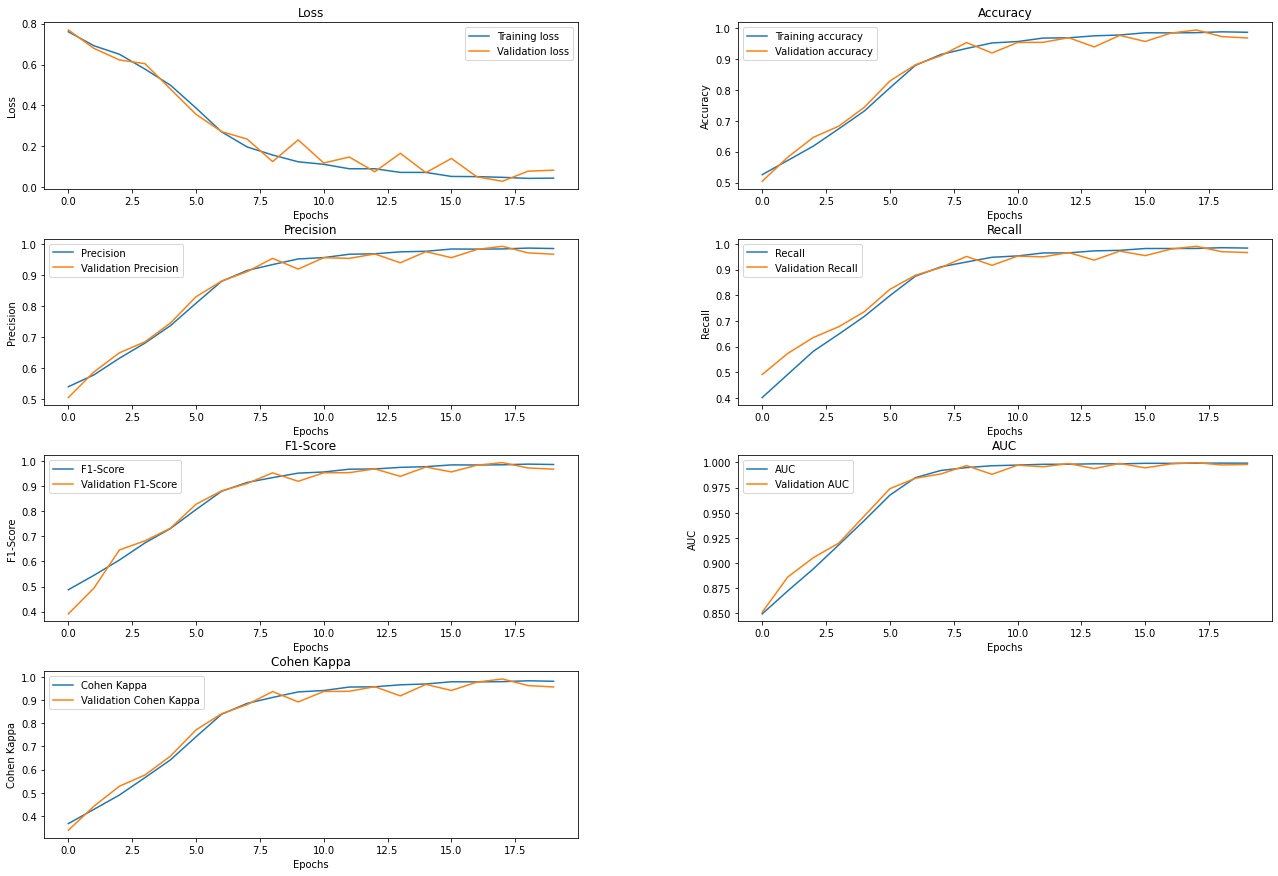

In [22]:
plot_history(history)

In [23]:
model.evaluate(test_generator)

211/211 [==============================] - 25s 120ms/step - loss: 0.0911 - categorical_accuracy: 0.9633 - precision: 0.9638 - recall: 0.9624 - f1_score: 0.9633 - auc: 0.9977 - cohen_kappa: 0.9510


[0.09105636179447174,
 0.9632701277732849,
 0.9638089537620544,
 0.9623815417289734,
 0.9633021354675293,
 0.9977486729621887,
 0.9510313272476196]

In [24]:
model.evaluate(valid_generator)

210/210 [==============================] - 22s 105ms/step - loss: 0.0839 - categorical_accuracy: 0.9673 - precision: 0.9675 - recall: 0.9670 - f1_score: 0.9673 - auc: 0.9981 - cohen_kappa: 0.9564


[0.08393286913633347,
 0.9672619104385376,
 0.9675402045249939,
 0.9669643044471741,
 0.9672539234161377,
 0.998077929019928,
 0.9563503861427307]

In [25]:
model.evaluate(train_generator)

1684/1684 [==============================] - 419s 249ms/step - loss: 0.0515 - categorical_accuracy: 0.9856 - precision: 0.9858 - recall: 0.9849 - f1_score: 0.9856 - auc: 0.9994 - cohen_kappa: 0.9808


[0.05153706297278404,
 0.9855626225471497,
 0.9858092665672302,
 0.9848945736885071,
 0.9856022000312805,
 0.9994062185287476,
 0.980750322341919]